In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pickle
import os
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%matplotlib inline

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
with open('../Data/mhealth_raw_data.pickle', 'rb') as f:
    df = pickle.load(f)

In [20]:
from sklearn.utils import resample
 
df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]
 
df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=42)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [21]:
df

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
154060,-0.68636,-5.2902,4.64530,0.13544,-0.83114,-0.13163,-8.4230,-6.6402,2.98050,-0.93922,0.090349,0.219830,0,subject1
936066,1.00030,-7.7902,-6.74410,-0.26531,-0.14447,-1.09820,2.2046,-7.5497,4.02880,-0.21961,-1.080100,0.303880,0,subject8
167106,1.53220,-9.5966,-0.25618,-0.27273,-0.75985,0.63654,-2.5898,-8.5217,3.83430,-0.88431,-0.848050,0.331900,0,subject2
493889,1.78090,-8.5942,-3.97440,-0.41002,-0.55535,-0.78389,-1.0049,-6.8588,2.11540,-0.35686,-0.854210,-0.415950,0,subject4
355024,-0.34940,-9.5201,1.45800,-0.68275,-0.77861,-0.24558,-1.4178,-9.5157,1.43050,-0.12353,-0.967150,-0.497840,0,subject3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1213641,-2.48730,-19.2330,3.46140,0.61967,-0.33771,-0.82711,-8.2348,-4.9652,2.48090,-0.43725,-1.018500,0.079741,12,subject10
1213642,-21.59100,-19.4370,-6.04190,0.61967,-0.33771,-0.82711,-21.3180,-10.2130,3.65600,-0.43725,-1.018500,0.079741,12,subject10
1213643,7.54330,-19.2450,-2.66800,0.61967,-0.33771,-0.82711,-21.2970,-18.7050,4.46060,-0.43725,-1.018500,0.079741,12,subject10
1213644,3.01420,-19.3340,-7.70740,0.71058,-0.27017,-0.75442,-21.1380,-18.6980,1.15880,-0.42549,-1.037000,0.084052,12,subject10


In [22]:
#Dropping feature have data outside 98% confidence interval
df1 = df.copy()
for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)

alx range: -11.47312 to 19.233
shape (365733, 14)
aly range: -19.379 to 2.447871999999997
shape (360018, 14)
alz range: -18.95 to 14.19623999999999
shape (356270, 14)
glx range: -0.74212 to 0.80705
shape (349377, 14)
gly range: -1.0694 to 0.96623
shape (342841, 14)
glz range: -1.1061 to 0.8290799999999999
shape (337391, 14)
arx range: -21.492 to 9.097647999999998
shape (332307, 14)
ary range: -18.694000000000003 to 11.948059999999998
shape (326241, 14)
arz range: -10.367 to 11.823119999999996
shape (323674, 14)
grx range: -1.0196 to 0.95686
shape (320188, 14)
gry range: -1.1417 to 0.90965
shape (315352, 14)
grz range: -0.69828 to 1.125
shape (310929, 14)


In [23]:
label_map = {
    0: 'Nothing',
    1: 'Standing still',  
    2: 'Sitting and relaxing', 
    3: 'Lying down',  
    4: 'Walking',  
    5: 'Climbing stairs',  
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms', 
    8: 'Knees bending (crouching)', 
    9: 'Cycling', 
    10: 'Jogging', 
    11: 'Running', 
    12: 'Jump front & back' 
}

In [24]:
print(df1.shape)
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

(310929, 14)


((246501, 14), (64428, 14))

In [25]:
X_train = train.drop(['Activity','subject'],axis=1)
y_train = train['Activity']
X_test = test.drop(['Activity','subject'],axis=1)
y_test = test['Activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((246501, 12), (246501,), (64428, 12), (64428,))

In [26]:
from scipy import stats

#function to create time series datset for seuence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [27]:
X_train_copy ,y_train_copy = create_dataset(X_train, y_train, 100, step=50)
X_train_copy.shape, y_train_copy.shape

((4929, 100, 12), (4929, 1))

In [28]:
X_test_copy,y_test_copy = create_dataset(X_test, y_test, 100, step=50)
X_test_copy.shape, y_test_copy.shape

((1287, 100, 12), (1287, 1))

In [55]:
model = keras.Sequential()
model.add(layers.Input(shape=[100,12]))
model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPool1D(2))
model.add(layers.LSTM(64))
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dense(13, activation='softmax'))

In [63]:
model

Net(
  (conv1): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [71]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=100, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        
        self.max_pool = nn.MaxPool1d(kernel_size=2)
        
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(in_features=64, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=13)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        x = self.max_pool(x)
        
        x = x.permute(0, 2, 1) # Permute to match LSTM input shape
        x, _ = self.lstm(x)
        x = x[:, -1, :] # Only take the last output of the LSTM
        
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

In [72]:
model = Net().to(DEVICE)

In [73]:
model

Net(
  (conv1): Conv1d(100, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=13, bias=True)
)

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

X_train1 = torch.from_numpy(X_train_copy).float().to(DEVICE)
y_train1 = torch.from_numpy(y_train_copy).long().to(DEVICE)

X_test1 = torch.from_numpy(X_test_copy).float().to(DEVICE)
y_test1 = torch.from_numpy(y_test_copy).long().to(DEVICE)

X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape

(torch.Size([4929, 100, 12]),
 torch.Size([4929, 1]),
 torch.Size([1287, 100, 12]),
 torch.Size([1287, 1]))

In [75]:
X_train1

tensor([[[ -0.6864,  -5.2902,   4.6453,  ...,  -0.9392,   0.0903,   0.2198],
         [  1.0003,  -7.7902,  -6.7441,  ...,  -0.2196,  -1.0801,   0.3039],
         [  1.5322,  -9.5966,  -0.2562,  ...,  -0.8843,  -0.8480,   0.3319],
         ...,
         [  3.6543,  -9.0272,  -0.7377,  ...,  -0.0902,  -0.8727,  -0.6703],
         [  0.9086,  -9.5871,   1.6860,  ...,  -0.6882,  -0.8275,   0.0905],
         [  0.3465,  -7.6891,  -0.5893,  ...,  -0.1765,  -1.0267,  -0.3944]],

        [[  0.8306,  -5.2852,  -0.7976,  ...,  -0.1863,  -0.7680,   0.8922],
         [  2.0891,  -9.5404,   1.4085,  ...,  -0.1863,   0.0308,   1.1228],
         [  0.3504,  -8.0943,   2.4530,  ...,  -0.7490,   0.2382,   0.5172],
         ...,
         [-11.3560,  -8.9798,  -8.8751,  ...,  -0.3823,  -0.6037,  -0.5840],
         [  1.9896, -10.3180,  -0.1314,  ...,  -0.5941,   0.1725,   1.0108],
         [ -0.0558,  -9.4624,   1.2867,  ...,  -0.2000,  -0.7988,   0.8082]],

        [[  0.1517,  -9.7090,   1.3807,  ...

  3%|▎         | 3/100 [00:00<00:05, 18.98it/s]

Epoch: 0 Train Loss: 2.5650 Train Acc: 0.1674 Test Acc: 0.2036
Epoch: 1 Train Loss: 2.5637 Train Acc: 0.1601 Test Acc: 0.2067
Epoch: 2 Train Loss: 2.5625 Train Acc: 0.1580 Test Acc: 0.2168
Epoch: 3 Train Loss: 2.5612 Train Acc: 0.1887 Test Acc: 0.2385


  9%|▉         | 9/100 [00:00<00:03, 25.23it/s]

Epoch: 4 Train Loss: 2.5598 Train Acc: 0.1864 Test Acc: 0.2230
Epoch: 5 Train Loss: 2.5582 Train Acc: 0.1804 Test Acc: 0.1989
Epoch: 6 Train Loss: 2.5562 Train Acc: 0.1952 Test Acc: 0.1841
Epoch: 7 Train Loss: 2.5541 Train Acc: 0.2128 Test Acc: 0.1515
Epoch: 8 Train Loss: 2.5515 Train Acc: 0.2439 Test Acc: 0.2028
Epoch: 9 Train Loss: 2.5484 Train Acc: 0.2552 Test Acc: 0.2044
Epoch: 10 Train Loss: 2.5448 Train Acc: 0.2844 Test Acc: 0.2020


 17%|█▋        | 17/100 [00:00<00:02, 31.04it/s]

Epoch: 11 Train Loss: 2.5406 Train Acc: 0.2917 Test Acc: 0.1981
Epoch: 12 Train Loss: 2.5358 Train Acc: 0.3041 Test Acc: 0.2510
Epoch: 13 Train Loss: 2.5302 Train Acc: 0.2952 Test Acc: 0.2626
Epoch: 14 Train Loss: 2.5237 Train Acc: 0.2853 Test Acc: 0.2696
Epoch: 15 Train Loss: 2.5164 Train Acc: 0.2944 Test Acc: 0.2704
Epoch: 16 Train Loss: 2.5082 Train Acc: 0.3132 Test Acc: 0.3077
Epoch: 17 Train Loss: 2.4992 Train Acc: 0.2990 Test Acc: 0.2836


 25%|██▌       | 25/100 [00:00<00:02, 33.54it/s]

Epoch: 18 Train Loss: 2.4895 Train Acc: 0.2767 Test Acc: 0.2844
Epoch: 19 Train Loss: 2.4794 Train Acc: 0.2672 Test Acc: 0.2844
Epoch: 20 Train Loss: 2.4692 Train Acc: 0.2627 Test Acc: 0.2844
Epoch: 21 Train Loss: 2.4592 Train Acc: 0.2633 Test Acc: 0.2844
Epoch: 22 Train Loss: 2.4495 Train Acc: 0.2633 Test Acc: 0.2844
Epoch: 23 Train Loss: 2.4401 Train Acc: 0.2635 Test Acc: 0.2844
Epoch: 24 Train Loss: 2.4311 Train Acc: 0.2635 Test Acc: 0.2844
Epoch: 25 Train Loss: 2.4222 Train Acc: 0.2637 Test Acc: 0.2844


 33%|███▎      | 33/100 [00:01<00:01, 35.31it/s]

Epoch: 26 Train Loss: 2.4135 Train Acc: 0.2639 Test Acc: 0.2844
Epoch: 27 Train Loss: 2.4046 Train Acc: 0.2642 Test Acc: 0.2844
Epoch: 28 Train Loss: 2.3955 Train Acc: 0.2654 Test Acc: 0.2875
Epoch: 29 Train Loss: 2.3865 Train Acc: 0.2715 Test Acc: 0.2914
Epoch: 30 Train Loss: 2.3776 Train Acc: 0.2812 Test Acc: 0.2976
Epoch: 31 Train Loss: 2.3690 Train Acc: 0.2905 Test Acc: 0.3077
Epoch: 32 Train Loss: 2.3600 Train Acc: 0.3009 Test Acc: 0.3256
Epoch: 33 Train Loss: 2.3508 Train Acc: 0.3161 Test Acc: 0.3349


 41%|████      | 41/100 [00:01<00:01, 36.43it/s]

Epoch: 34 Train Loss: 2.3409 Train Acc: 0.3352 Test Acc: 0.3473
Epoch: 35 Train Loss: 2.3306 Train Acc: 0.3709 Test Acc: 0.3737
Epoch: 36 Train Loss: 2.3203 Train Acc: 0.3885 Test Acc: 0.3963
Epoch: 37 Train Loss: 2.3094 Train Acc: 0.4256 Test Acc: 0.4577
Epoch: 38 Train Loss: 2.2976 Train Acc: 0.4480 Test Acc: 0.4911
Epoch: 39 Train Loss: 2.2855 Train Acc: 0.4538 Test Acc: 0.4996
Epoch: 40 Train Loss: 2.2724 Train Acc: 0.4733 Test Acc: 0.5152
Epoch: 41 Train Loss: 2.2594 Train Acc: 0.4784 Test Acc: 0.5167


 49%|████▉     | 49/100 [00:01<00:01, 36.73it/s]

Epoch: 42 Train Loss: 2.2467 Train Acc: 0.4825 Test Acc: 0.5190
Epoch: 43 Train Loss: 2.2351 Train Acc: 0.4827 Test Acc: 0.5152
Epoch: 44 Train Loss: 2.2244 Train Acc: 0.4865 Test Acc: 0.5190
Epoch: 45 Train Loss: 2.2141 Train Acc: 0.4863 Test Acc: 0.5214
Epoch: 46 Train Loss: 2.2040 Train Acc: 0.4871 Test Acc: 0.5206
Epoch: 47 Train Loss: 2.1942 Train Acc: 0.4881 Test Acc: 0.5198
Epoch: 48 Train Loss: 2.1844 Train Acc: 0.4869 Test Acc: 0.5167
Epoch: 49 Train Loss: 2.1753 Train Acc: 0.4867 Test Acc: 0.5245


 57%|█████▋    | 57/100 [00:01<00:01, 36.98it/s]

Epoch: 50 Train Loss: 2.1692 Train Acc: 0.4940 Test Acc: 0.5330
Epoch: 51 Train Loss: 2.1576 Train Acc: 0.5070 Test Acc: 0.5835
Epoch: 52 Train Loss: 2.1450 Train Acc: 0.3972 Test Acc: 0.4095
Epoch: 53 Train Loss: 2.1466 Train Acc: 0.5890 Test Acc: 0.6333
Epoch: 54 Train Loss: 2.1228 Train Acc: 0.6070 Test Acc: 0.6791
Epoch: 55 Train Loss: 2.1172 Train Acc: 0.6470 Test Acc: 0.6799
Epoch: 56 Train Loss: 2.0973 Train Acc: 0.4782 Test Acc: 0.4328
Epoch: 57 Train Loss: 2.0942 Train Acc: 0.5827 Test Acc: 0.6123


 65%|██████▌   | 65/100 [00:01<00:00, 36.26it/s]

Epoch: 58 Train Loss: 2.0769 Train Acc: 0.7377 Test Acc: 0.7133
Epoch: 59 Train Loss: 2.0575 Train Acc: 0.7279 Test Acc: 0.7156
Epoch: 60 Train Loss: 2.0508 Train Acc: 0.7389 Test Acc: 0.6752
Epoch: 61 Train Loss: 2.0313 Train Acc: 0.6892 Test Acc: 0.6200
Epoch: 62 Train Loss: 2.0290 Train Acc: 0.7306 Test Acc: 0.7086
Epoch: 63 Train Loss: 2.0040 Train Acc: 0.7221 Test Acc: 0.7047
Epoch: 64 Train Loss: 1.9935 Train Acc: 0.7395 Test Acc: 0.7211
Epoch: 65 Train Loss: 1.9732 Train Acc: 0.7241 Test Acc: 0.6294


 73%|███████▎  | 73/100 [00:02<00:00, 36.74it/s]

Epoch: 66 Train Loss: 1.9620 Train Acc: 0.7651 Test Acc: 0.6908
Epoch: 67 Train Loss: 1.9433 Train Acc: 0.7738 Test Acc: 0.6799
Epoch: 68 Train Loss: 1.9342 Train Acc: 0.7910 Test Acc: 0.7203
Epoch: 69 Train Loss: 1.9239 Train Acc: 0.7971 Test Acc: 0.7009
Epoch: 70 Train Loss: 1.9123 Train Acc: 0.7894 Test Acc: 0.6915
Epoch: 71 Train Loss: 1.9033 Train Acc: 0.8162 Test Acc: 0.7529
Epoch: 72 Train Loss: 1.8940 Train Acc: 0.8221 Test Acc: 0.7615
Epoch: 73 Train Loss: 1.8879 Train Acc: 0.8255 Test Acc: 0.7653


 81%|████████  | 81/100 [00:02<00:00, 37.11it/s]

Epoch: 74 Train Loss: 1.8819 Train Acc: 0.8294 Test Acc: 0.7677
Epoch: 75 Train Loss: 1.8741 Train Acc: 0.8320 Test Acc: 0.7700
Epoch: 76 Train Loss: 1.8690 Train Acc: 0.8365 Test Acc: 0.7723
Epoch: 77 Train Loss: 1.8641 Train Acc: 0.8405 Test Acc: 0.7770
Epoch: 78 Train Loss: 1.8605 Train Acc: 0.8444 Test Acc: 0.7848
Epoch: 79 Train Loss: 1.8567 Train Acc: 0.8468 Test Acc: 0.7972
Epoch: 80 Train Loss: 1.8539 Train Acc: 0.8489 Test Acc: 0.7995
Epoch: 81 Train Loss: 1.8512 Train Acc: 0.8507 Test Acc: 0.8011


 89%|████████▉ | 89/100 [00:02<00:00, 37.12it/s]

Epoch: 82 Train Loss: 1.8490 Train Acc: 0.8521 Test Acc: 0.8019
Epoch: 83 Train Loss: 1.8469 Train Acc: 0.8537 Test Acc: 0.8081
Epoch: 84 Train Loss: 1.8451 Train Acc: 0.8549 Test Acc: 0.8135
Epoch: 85 Train Loss: 1.8436 Train Acc: 0.8551 Test Acc: 0.8197
Epoch: 86 Train Loss: 1.8422 Train Acc: 0.8555 Test Acc: 0.8213
Epoch: 87 Train Loss: 1.8412 Train Acc: 0.8560 Test Acc: 0.8252
Epoch: 88 Train Loss: 1.8403 Train Acc: 0.8562 Test Acc: 0.8283
Epoch: 89 Train Loss: 1.8394 Train Acc: 0.8560 Test Acc: 0.8291


 97%|█████████▋| 97/100 [00:02<00:00, 37.33it/s]

Epoch: 90 Train Loss: 1.8387 Train Acc: 0.8564 Test Acc: 0.8275
Epoch: 91 Train Loss: 1.8380 Train Acc: 0.8566 Test Acc: 0.8275
Epoch: 92 Train Loss: 1.8373 Train Acc: 0.8566 Test Acc: 0.8267
Epoch: 93 Train Loss: 1.8367 Train Acc: 0.8568 Test Acc: 0.8291
Epoch: 94 Train Loss: 1.8362 Train Acc: 0.8570 Test Acc: 0.8298
Epoch: 95 Train Loss: 1.8357 Train Acc: 0.8576 Test Acc: 0.8314
Epoch: 96 Train Loss: 1.8352 Train Acc: 0.8578 Test Acc: 0.8322
Epoch: 97 Train Loss: 1.8349 Train Acc: 0.8580 Test Acc: 0.8329


100%|██████████| 100/100 [00:02<00:00, 34.93it/s]


Epoch: 98 Train Loss: 1.8345 Train Acc: 0.8580 Test Acc: 0.8337
Epoch: 99 Train Loss: 1.8342 Train Acc: 0.8578 Test Acc: 0.8337


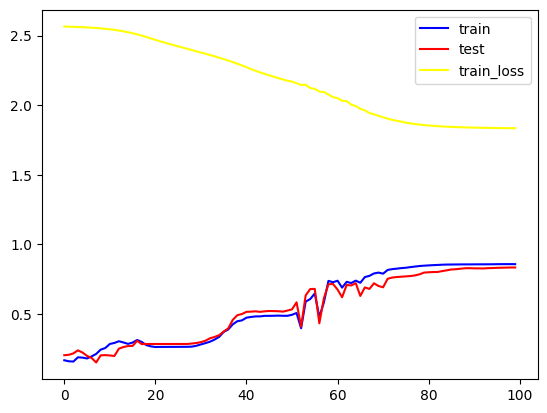

In [76]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def train(model, X_train, y_train, X_test, y_test, optimizer, loss_fn, epochs=10):
    train_acc = []
    test_acc = []
    train_loss =[]
    test_loss = []
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train.squeeze())
        loss.backward()
        optimizer.step()
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            y_pred_test = model(X_test)
            train_acc.append(accuracy_score(y_train.cpu(), y_pred_train.cpu().argmax(1)))
            test_acc.append(accuracy_score(y_test.cpu(), y_pred_test.cpu().argmax(1)))
            train_loss.append(loss.item())
            print('Epoch: {} Train Loss: {:.4f} Train Acc: {:.4f} Test Acc: {:.4f}'.format(epoch, loss.item(), train_acc[-1], test_acc[-1]))
    return train_acc, test_acc, train_loss


train_acc, test_acc, train_loss = train(model, X_train1, y_train1, X_test1, y_test1, optimizer, loss_fn, epochs=100)

plt.plot(train_acc, label='train', color = 'b')

plt.plot(test_acc, label='test', color = 'r')

plt.plot(train_loss, label = 'train_loss', color = 'yellow')

plt.legend()

plt.show()

